## 1. Use Google Drive link to view a folder I shared with @columbia.edu google drive users
https://drive.google.com/drive/folders/18O-BnGOIw9ZiUwy17Uk_361xyfTF-qAN?usp=sharing
## 2. Right click folder and click "Add shortcut to Drive"
This will be sure the zipfile in this folder is accessible in your personal drive folder


In [ ]:
# Begin to submit models to image classification leaderboard
! pip install aimodelshare --upgrade
# Restart session Runtime > Restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 967.8/967.8 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 KB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 99.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.3/442.3 KB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 93.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 KB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.3/9

In [ ]:
# Connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

# content in your drive is now available via "/content/drive/My Drive"


Mounted at /content/drive


In [ ]:
# Import data and unzip files to folder
!unzip /content/drive/MyDrive/COVID-19_Radiography_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7933.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7934.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7935.png  
 

In [ ]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images'] #0 1 2

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
#print(fnames[0:2]) #examples of file names

number of images for each category: [3616, 10192, 1345]


In [ ]:
#Reduce number of images to first 1344 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [ ]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img



#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [ ]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [ ]:
len(image_filepaths)

4032

In [ ]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


4032
(4032, 192, 192, 3)
-0.0
1.0


In [ ]:
print(len(fnames[2]),len(fnames[1]), len(fnames[0]))

1344 1344 1344


In [ ]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


COVID  NORMAL  PNEUMONIA
0         1       0          0
1         1       0          0
2         1       0          0
3         1       0          0
4         1       0          0
...     ...     ...        ...
4027      0       0          1
4028      0       0          1
4029      0       0          1
4030      0       0          1
4031      0       0          1

[4032 rows x 3 columns]

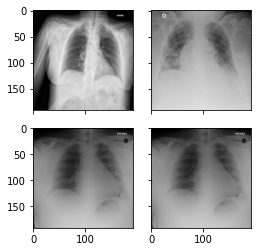

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor(fnames[0][0])
im2 =preprocessor(fnames[0][1])
im3 =preprocessor(fnames[1][1])
im4 =preprocessor(fnames[1][1])

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

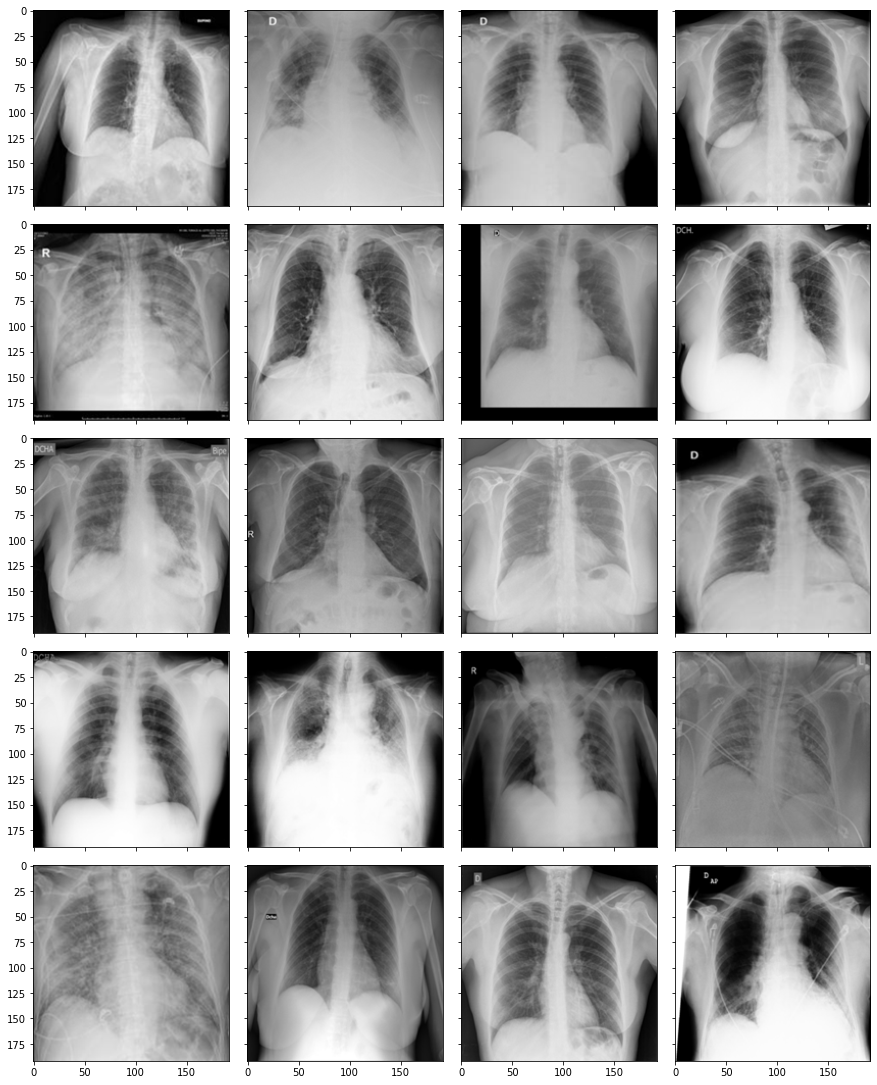

In [ ]:
# 1344 per category 
# only show 20 per category
# Visualize images that demonstrate when x-rays demonstrate Covid Positivity
# 20 images in the catrgory of COVID postive

fig = plt.figure(figsize=(15, 25))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 4),  # creates 2x2 grid of axes
                 axes_pad=0.25,
                 )
for ax, im in zip(grid, fnames[0][:20]):
    # Iterating over the grid returns the Axes.
    ax.imshow(preprocessor(im))
plt.show()

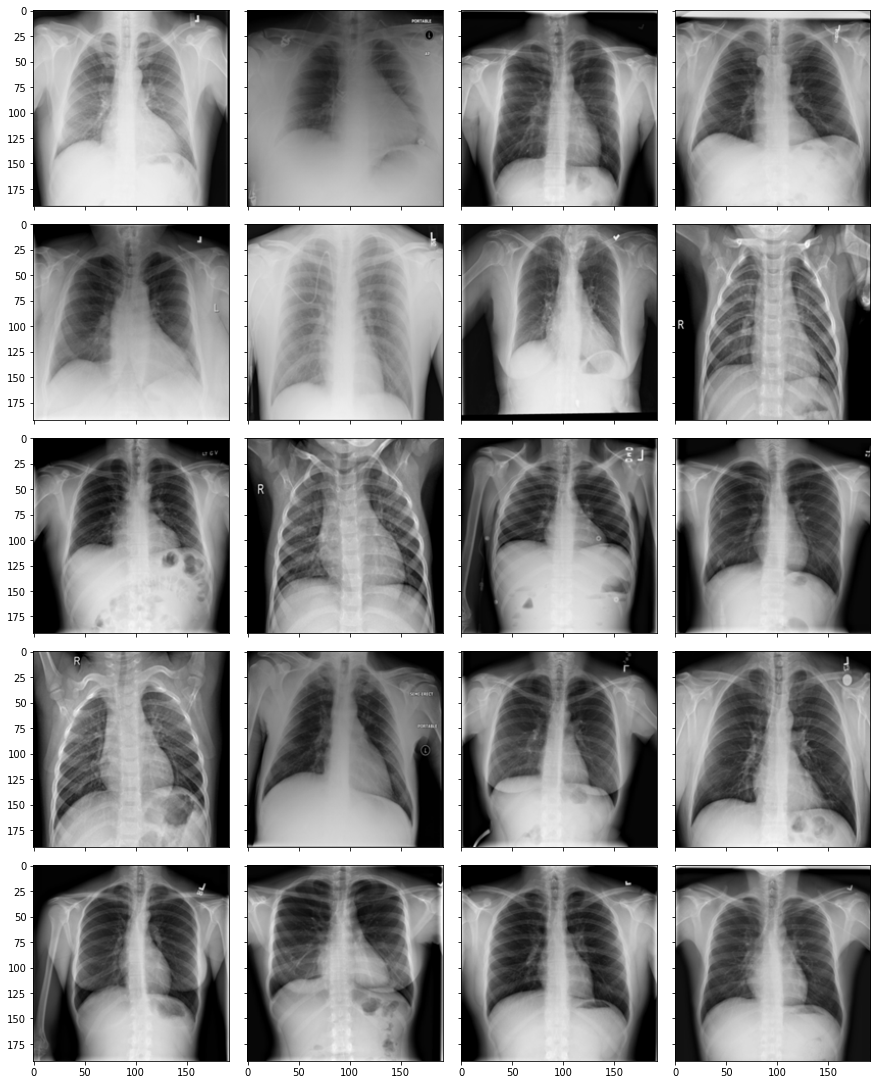

In [ ]:
# 20 images of normal x-ray
fig = plt.figure(figsize=(15, 25))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 4),  # creates 2x2 grid of axes
                 axes_pad=0.25,
                 )
for ax, im in zip(grid, fnames[1][:20]):
    # Iterating over the grid returs the Axes.
    ax.imshow(preprocessor(im))
plt.show()

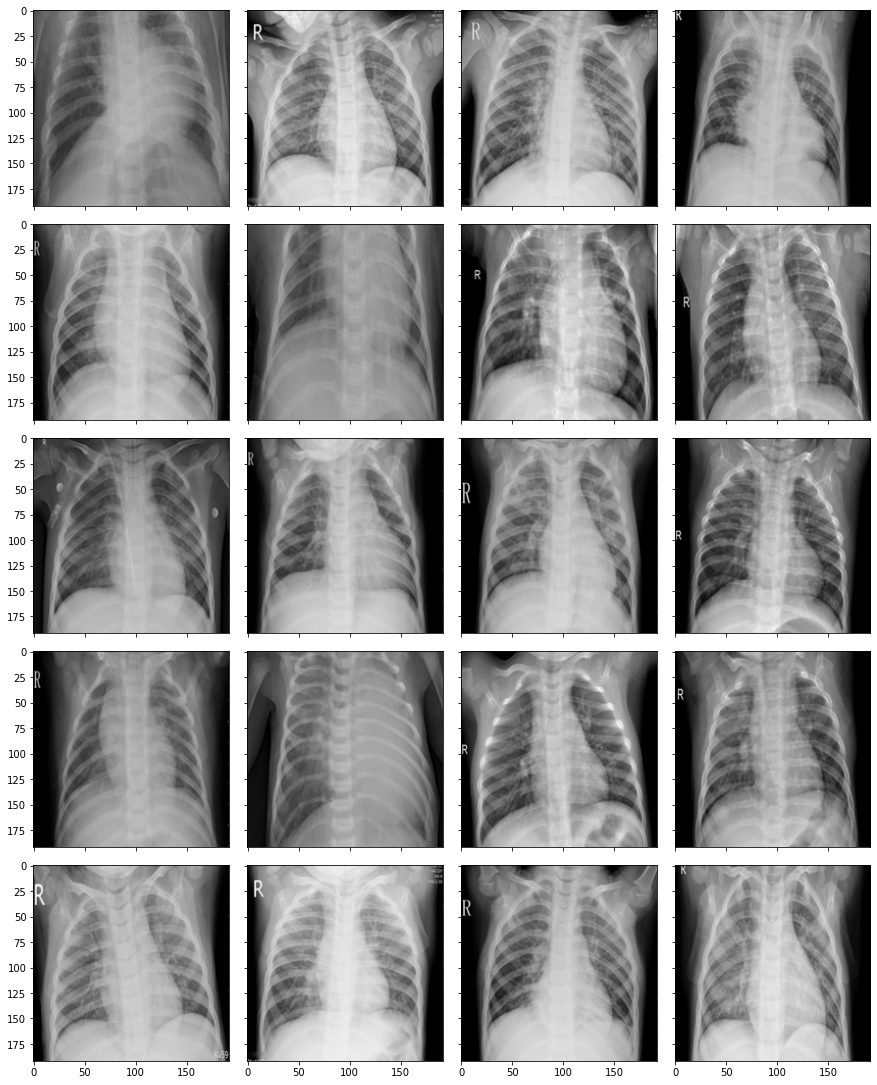

In [ ]:
# 20 images of Viral Pneumonia x-ray
fig = plt.figure(figsize=(15, 25))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 4),  # creates 2x2 grid of axes
                 axes_pad=0.25,
                 )
for ax, im in zip(grid, fnames[2][:20]):
    # Iterating over the grid returns the Axes.
    ax.imshow(preprocessor(im))
plt.show()

In [ ]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

**Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.**

The orginal dataset contains the chest x-ray images of COVID postive people, normal people, viral pneumonia people as well as lung opacity images. In this report, we only extracted the first three catogories namely images of lungs with COVID positive, normal lungs and lungs with viral pneumonia , containing 3616, 10192 and 1345 images respectively. Then the number of images in the dataset is reduced to the first 1344 images for each category, so we will have a balanced dataset with 1344 images for each category. 

As we all know, COVID-19 is a disease that spreads quickly and easily and is highly contagious with cases occurring worldwide and has a huge impact on people's life. The pandemic has resulted in extensive sickness and fatalities, interrupted economies, burdened healthcare systems, and necessitated individuals to adjust to novel ways to live, work, study, and social interaction.

Deep learning predictive models are particularly well-suited for image analysis. Building a predictive model using chest x-ray images can facilitate the early identification and diagnosis of COVID-19, potentially leading to a reduction in the number of infections. As COVID-19 symptoms may resemble those of other respiratory and lung illnesses, the predictive model utilizing X-ray images can aid in distinguishing between COVID-19 and viral pneumonia. People, specifically both doctors and patients as well as researchers, can benefit from a predicitve model like this using this kind of data, as it has the potential to accurately diagnose COVID-19 efficiently and effecitvely and enable doctors to provide better treatment strategies to patients. The predictive model has the potential to detect COVID-19 in patients by analyzing their X-ray images, enabling medical professionals to identify the disease at an early stage, which is essential for effective treatment and preventing the virus's transmission. The model can rapidly and precisely evaluate vast amounts of X-ray images, decreasing the workload of medical professionals and accelerating the diagnostic process. Also building a predictive model using the chest x-ray images can help researchers save time and resources to do the reseach of COVID-19 and similar diseases.

In [ ]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [ ]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

#Save data
import pickle

# Open a file and use dump()
with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

#Save data
import pickle

# Open a file and use dump()
with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)


# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

In [ ]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

**The First Model**: Keras Convolutional Neural Network Model

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 3, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Epoch 1/3
69/69 [==============================] - 5s 69ms/step - loss: 0.7421 - accuracy: 0.6432 - val_loss: 0.5953 - val_accuracy: 0.7268
Epoch 2/3
69/69 [==============================] - 4s 57ms/step - loss: 0.5031 - accuracy: 0.7838 - val_loss: 0.4612 - val_accuracy: 0.8087
Epoch 3/3
69/69 [==============================] - 4s 54ms/step - loss: 0.3772 - accuracy: 0.8531 - val_loss: 0.3825 - val_accuracy: 0.8579


In [ ]:
model.save("model1.h5", save_format="h5")

In [ ]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model1.h5',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 192, 192, 32)      896       
                                                                 
 conv2d_47 (Conv2D)          (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 96, 96, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 96, 96, 32)        9248      
                                                                 
 conv2d_49 (Conv2D)          (None, 96, 96, 32)        1056      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                 

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

41/41 [==============================] - 1s 23ms/step


In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                        custom_metadata={"team":"4"})


Insert search tags to help users find your model (optional): yh3513_m1
Provide any useful notes about your model (optional): yh3513

Your model has been submitted as model version 337

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
#data = experiment.get_leaderboard()
#experiment.stylize_leaderboard(data)

In [ ]:
# #Submit Model with predictions only (if you cannot save an onnx file): 

# #-- Generate predicted y values (Model 1)
# #Note: Keras predict returns the predicted column index location for classification models
# prediction_column_index=model.predict(X_test).argmax(axis=1)

# # extract correct prediction labels 
# prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# # Submit Model 1 to Competition Leaderboard
# experiment.submit_model(model_filepath = None,
#                                  preprocessor_filepath=None,
#                                  prediction_submission=prediction_labels)

**The Second Model**: Transfer Learning Model

In [ ]:
# Create the base model from the pre-trained model VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

base_model = VGG16(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [ ]:
# Freeze the weights of the VGG16 model so that they are not trained when you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.
base_model.trainable = False

base_model.summary() 

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(112, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)

# define new model
model2 = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model

# summarize
model2.summary()
     

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0   

In [ ]:
# Fit VGG16 model with frozen imagent weights and new input/output layer shapes (outputs have trainable parameters)
import tensorflow as tf
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model2.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  model2.fit(X_train, y_train,batch_size=1,
          epochs = 1, verbose=1,validation_split=.2,callbacks=[mc,red_lr])

2189/2192 [============================>.] - ETA: 0s - loss: 1.1352 - acc: 0.3335
Epoch 00001: val_acc improved from -inf to 0.32058, saving model to best_model.h5
2192/2192 [==============================] - 28s 12ms/step - loss: 1.1351 - acc: 0.3339 - val_loss: 1.1094 - val_acc: 0.3206 - lr: 0.0100


In [ ]:
model2.save("model2.h5", save_format="h5")

In [ ]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0   

In [ ]:
onnx_model2 = model_to_onnx(model2, framework='keras',
                          transfer_learning= True,
                          deep_learning=True)

with open("model2.onnx", "wb") as f:
    f.write(onnx_model2.SerializeToString())

In [ ]:
prediction_column_index=model2.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

41/41 [==============================] - 8s 141ms/step


In [ ]:
experiment.submit_model(model_filepath = "model2.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                        custom_metadata={"team":"4"})

Insert search tags to help users find your model (optional): yh3513_m2
Provide any useful notes about your model (optional): yh3513

Your model has been submitted as model version 338

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


**The Third Model**

In [ ]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  model3 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  model3.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  model3.fit(X_train, y_train,
                    epochs = 5, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts l

Epoch 1/5
69/69 [==============================] - 8s 98ms/step - loss: 1.3442 - accuracy: 0.7404 - val_loss: 1.0182 - val_accuracy: 0.5993
Epoch 2/5
69/69 [==============================] - 6s 83ms/step - loss: 0.3050 - accuracy: 0.8859 - val_loss: 1.0597 - val_accuracy: 0.4226
Epoch 3/5
69/69 [==============================] - 6s 84ms/step - loss: 0.2078 - accuracy: 0.9247 - val_loss: 1.0586 - val_accuracy: 0.4882
Epoch 4/5
69/69 [==============================] - 6s 89ms/step - loss: 0.1170 - accuracy: 0.9539 - val_loss: 0.7806 - val_accuracy: 0.6594
Epoch 5/5
69/69 [==============================] - 6s 85ms/step - loss: 0.0912 - accuracy: 0.9662 - val_loss: 0.7716 - val_accuracy: 0.7505


In [ ]:
model3.save("model3.h5", save_format="h5")

In [ ]:
model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 192, 192, 32)      896       
                                                                 
 conv2d_57 (Conv2D)          (None, 192, 192, 32)      1056      
                                                                 
 batch_normalization_2 (Batc  (None, 192, 192, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 96, 96, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 conv2d_59 (Conv2D)          (None, 96, 96, 64)       

In [ ]:
onnx_model3 = model_to_onnx(model3, framework='keras',
                          transfer_learning= True,
                          deep_learning=True)

with open("model3.onnx", "wb") as f:
    f.write(onnx_model3.SerializeToString())

In [ ]:
prediction_column_index=model3.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

41/41 [==============================] - 1s 29ms/step


In [ ]:
experiment.submit_model(model_filepath = "model3.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                        custom_metadata={"team":"4"})

Insert search tags to help users find your model (optional): yh3513_m3
Provide any useful notes about your model (optional): yh3513

Your model has been submitted as model version 340

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

From the leaderboard, we can see that the first model performs better than others and the third model performs better than the second one only. The first model has 3 epochs, 2 layers with filter size 32 and kernel size 3, 2 layers with filter size 32 and kernel size 1, 1 layer with filter size 64 and kernel size 3, 1 layer with filter size 64 and kernel size 1, 1 layer with filtersize 128 and kernel size 3 and 1 layer with filter size 128 and kernel size 1. The second model only takes 1 epoch due to the chance of running out the memory, and its performance may get improved with more epochs. The third model with batch normalization has fewer layers than the first one, but more epochs.

**After discussion, the fourth model**

In [ ]:
import tensorflow as tf
from tensorflow.keras import regularizers
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  model4 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=16, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  model4.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  model4.fit(X_train, y_train,
                    epochs = 5, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts l

Epoch 1/5
69/69 [==============================] - 7s 80ms/step - loss: 2.8741 - accuracy: 0.7491 - val_loss: 2.7123 - val_accuracy: 0.3242
Epoch 2/5
69/69 [==============================] - 3s 45ms/step - loss: 1.7570 - accuracy: 0.9138 - val_loss: 2.5455 - val_accuracy: 0.5537
Epoch 3/5
69/69 [==============================] - 3s 46ms/step - loss: 1.4872 - accuracy: 0.9489 - val_loss: 2.3546 - val_accuracy: 0.5228
Epoch 4/5
69/69 [==============================] - 3s 49ms/step - loss: 1.2746 - accuracy: 0.9799 - val_loss: 2.0231 - val_accuracy: 0.5829
Epoch 5/5
69/69 [==============================] - 3s 50ms/step - loss: 1.1269 - accuracy: 0.9891 - val_loss: 1.8443 - val_accuracy: 0.6175


In [ ]:
model4.save("model4.h5", save_format="h5")

In [ ]:
model4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 192, 192, 16)      448       
                                                                 
 conv2d_63 (Conv2D)          (None, 192, 192, 16)      272       
                                                                 
 batch_normalization_4 (Batc  (None, 192, 192, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 96, 96, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 96, 96, 32)        4640      
                                                                 
 conv2d_65 (Conv2D)          (None, 96, 96, 32)       

In [ ]:
onnx_model4 = model_to_onnx(model4, framework='keras',
                          transfer_learning= True,
                          deep_learning=True)

with open("model4.onnx", "wb") as f:
    f.write(onnx_model4.SerializeToString())

In [ ]:
prediction_column_index=model4.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

41/41 [==============================] - 1s 21ms/step


In [ ]:
experiment.submit_model(model_filepath = "model4.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                        custom_metadata={"team":"4"})

Insert search tags to help users find your model (optional): yh3513_m3
Provide any useful notes about your model (optional): m4

Your model has been submitted as model version 341

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

After discussion with my team and learning from them, the fourth model is trained with bach normalization, L2 regularization, 2 layers of filter size 16, 2 layers of filter size 32, 2 layers of filter size 64 and 5 epochs. The performance of the fourth model is better than the second model, maybe because of more epochs. The performance of third model is better than this one, maybe because of the filter sizes. Still the first model has the best performance among these 4 models.

**Try to use augmented data to rerun at least one model and submit it to the leaderboard**

In [ ]:
#Augment Image Data Using Keras ImageDataGenerator()
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from itertools import repeat

In [ ]:
filenamelist=fnames[0]+fnames[1]+fnames[2]

covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

y = covid+normal+pneumonia

print(len(y), len(filenamelist))

4032 4032


In [ ]:
X_train_datagen, X_test_datagen, y_train_datagen, y_test_datagen = train_test_split(filenamelist, y, test_size = 0.32, random_state = 1987)

In [ ]:
traindf = pd.DataFrame.from_dict({'X': X_train_datagen, 'y': y_train_datagen})
testdf = pd.DataFrame.from_dict({'X': X_test_datagen, 'y': y_test_datagen})   

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.5,
        horizontal_flip=True,
        vertical_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=traindf,
        directory=None,
        x_col="X",
        y_col="y",
        target_size=(192, 192),
        batch_size=1,
        class_mode='categorical',shuffle=True)

Found 2741 validated image filenames belonging to 3 classes.


In [ ]:
validation_generator = test_datagen.flow_from_dataframe(
        dataframe=testdf,
        directory=None,
        x_col="X",
        y_col="y",
        target_size=(192, 192),
        batch_size=1,
        class_mode='categorical')

Found 1291 validated image filenames belonging to 3 classes.


In [ ]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model5 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model5.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
      model5.fit(train_generator,
                    steps_per_epoch=len(traindf) / 1, epochs=1, validation_data=validation_generator)

2741/2741 [==============================] - 57s 20ms/step - loss: 1.3298 - accuracy: 0.5429 - val_loss: 1.1864 - val_accuracy: 0.5616


In [ ]:
model5.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model5.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_71 (Conv2D)          (None, 192, 192, 32)      896       
                                                                 
 conv2d_72 (Conv2D)          (None, 192, 192, 32)      1056      
                                                                 
 batch_normalization_6 (Batc  (None, 192, 192, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 96, 96, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_73 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 conv2d_74 (Conv2D)          (None, 96, 96, 64)       

In [ ]:
model5.save("model5.h5", save_format="h5")

In [ ]:
prediction_column_index=model5.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

41/41 [==============================] - 1s 24ms/step


In [ ]:
onnx_model5 = model_to_onnx(model5, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model5.onnx", "wb") as f:
    f.write(onnx_model5.SerializeToString())

In [ ]:
experiment.submit_model(model_filepath = "model5.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                        custom_metadata={"team":"4"})

Insert search tags to help users find your model (optional): yh3513_m3
Provide any useful notes about your model (optional): m5

Your model has been submitted as model version 348

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

This model is built on the third model with the same hyperparameters but 1 epoch due to the large dataset. However, the performance this fifth model with augmented data is not as well as the third one. This model performans better than the second one. I think with more epochs its performance might be better.

**Discuss which models you tried and which models performed better and point out relevant hyper-parameter values for successful models.**

I tried 5 models in total. All models are the CNN model for 3-class image classification in TensorFlow. The second model uses transfer learning. The fifth model with agumented data built on the third model. From the results in leaderboard, the first model has the best performance among these 5 models. Then the third model performs better than model 2, model 4 and model 5. Model 4 is bettern than both model 2 and model 5. Model 2 has the poorest performance.
Model 1 works better compares to the others. The relevant hyper-parameter values for this models are:

1. The first layer applies 32 filters of kernel size 3 to the input image, with ReLU activation. The padding parameter is the same padding. This layer has a input shape parameter of (192, 192, 3), which means the input images have a height and width of 192 pixels and 3 color channels (RGB).

2. The second layer applies 32 filters of kernel size 1 with the same padding and ReLU activation.

3. The following MaxPooling2D layer performs max pooling with a pool size of 2x2, reducing the height and width of the feature maps by half.

4. Then the Conv2D layer applies 32 filters of kernel size 3 with the same padding and ReLU activation.

5. The layer applies 32 filters of kernel size 1 with the same padding and ReLU activation followed by the same MaxPooling2D layer as before.

Repeat layer 4 and 5.

Then the layer applies 64 filters of kernel size 3 with the same padding and ReLU activation. And the layer applies 64 filters of kernel size 1 with the same padding and ReLU activation followed by the same MaxPooling2D layer as before.

Then 2 similar Conv2D layers with filter size 128 and the same hyperparameters

Then the Flatten layer flattens the output from the previous layer, turning it into a 1D tensor.

The output dense layer with 3 units, representing the 3 classes of this image classification problem. It has a softmax activation function which returns the probability of each class.


Citation of paper providing original dataset:  M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145